<a href="https://colab.research.google.com/github/IverMartinsen/colab_notebooks/blob/main/pca_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import modules, load and shuffle data { form-width: "35%" }

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from sklearn import datasets
from sklearn.decomposition import PCA

x = datasets.load_digits()['data'] / 16
y = datasets.load_digits()['target']

n = x.shape[0]

idx = np.random.choice(n, n, replace = False)
x_tr = x[idx[:1500], :]
x_te = x[idx[1500:], :]

In [ ]:
#@title Define model { form-width: "35%" }

class Encoder_2D(Model):
  def __init__(self, activation = None):
    super().__init__()
    
    #self.layer1 = Dense(32, activation = activation)
    #self.layer2 = Dense(16, activation = activation)
    #self.layer3 = Dense(2, activation = activation)

    self.kernel = self.add_weight("kernel",
                                  shape=[16, 2])

  def call(self, x):
    #x = self.layer1(x)
    #x = self.layer2(x)
    z = tf.matmul(x, self.kernel)
    z = tf.matmul(z, tf.transpose(self.kernel))
    return z

class Decoder_2D(Model):
  def __init__(self, activation = None):
    super().__init__()

    #self.layer1 = Dense(16, activation = activation)
    #self.layer2 = Dense(32, activation = activation)
    self.layer3 = Dense(64, activation = activation)

  def call(self, x):
    #x = self.layer1(x)
    #x = self.layer2(x)

    return self.layer3(x)

class Autoencoder_2D:
  def __init__(self, activation = None):
    self.encoder = Encoder_2D(activation)
    self.decoder = Decoder_2D(activation)
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss_object = tf.keras.losses.MeanSquaredError()
    self.test_loss = tf.keras.metrics.Sum()

  @tf.function
  def training_step(self, x):
    with tf.GradientTape(persistent = True) as tape:
      h = self.encoder(x)
      x_hat = self.decoder(h)
    
      loss = self.loss_object(x, x_hat)

    enc_grads = tape.gradient(loss, self.encoder.trainable_variables)
    dec_grads = tape.gradient(loss, self.decoder.trainable_variables)
  
    self.optimizer.apply_gradients(zip(enc_grads, self.encoder.trainable_variables))
    self.optimizer.apply_gradients(zip(dec_grads, self.decoder.trainable_variables))

  @tf.function
  def test_step(self, x):
    h = self.encoder(x)
    x_hat = self.decoder(h)

    loss = self.loss_object(x, x_hat)
    self.test_loss.update_state(loss)

  def train(self, x_tr, x_te, epochs = 1000):

    self.validation_loss = np.zeros(epochs)

    for i in range(epochs):
      self.training_step(x_tr)
      self.test_step(x_te)
      self.validation_loss[i] = float(self.test_loss.result())
      self.test_loss.reset_states()
    
  def encode(self, x):
    return self.encoder(x)

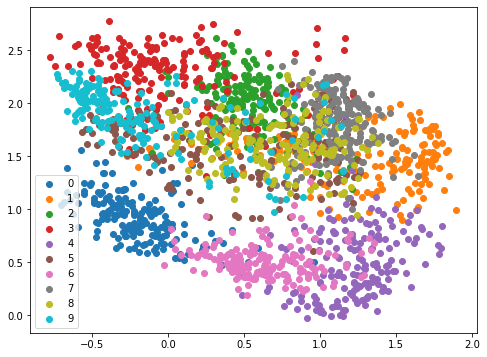

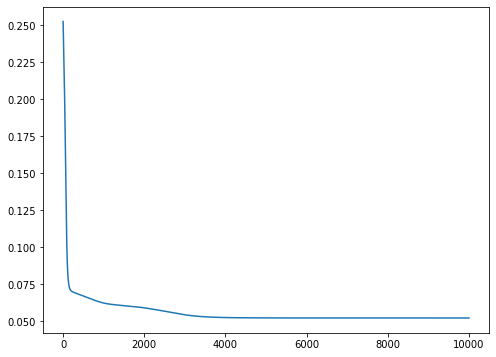

In [ ]:
#@title Run model and plot result { form-width : "35%"}

model = Autoencoder_2D()
model.train(x_tr, x_te, epochs = 10000)

x_reduced = np.array(model.encode(x))

fig = plt.figure(figsize=(8,6), facecolor='w', edgecolor='k')
for i in range(10):
  plt.scatter(x_reduced[np.where(y == i), 0], x_reduced[np.where(y == i), 1], label = str(i))
plt.legend()
fig = plt.figure(figsize=(8,6), facecolor='w', edgecolor='k')
plt.plot(model.validation_loss)

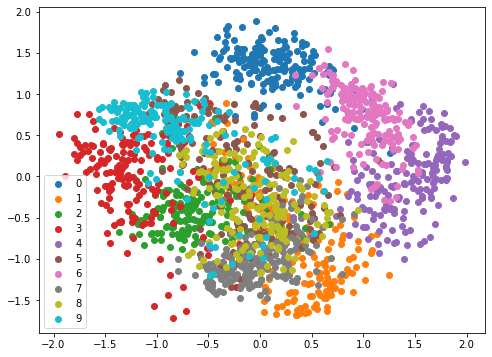

In [ ]:
#title @PCA

z = PCA(2).fit_transform(x)

fig = plt.figure(figsize = (8, 6))
for i in range(10):
  plt.scatter(z[np.where(y == i), 0], z[np.where(y == i), 1], label = str(i))
plt.legend()